**Problem Statement**

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
#functions 
#Function to print null values in all columns
def nulls(df):
    return (100*round(df.isnull().sum()/len(df),4).sort_values(ascending=False))
def getvif(df):
    if 'const' in list(df.columns):
        df1=df.drop('const', axis=1) 
    else:
        df1 = df.copy()
    vif=pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif.VIF,2)
    vif = vif.sort_values(by = 'VIF', ascending = False)
    return vif

In [4]:
#import dataset
df = pd.read_csv('../input/house-prices-data/train.csv')

## EDA and Missing Value Treatment

In [5]:
#inspecting df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
#checking null values
nulls(df)

PoolQC           99.52
MiscFeature      96.30
Alley            93.77
Fence            80.75
FireplaceQu      47.26
LotFrontage      17.74
GarageCond        5.55
GarageType        5.55
GarageYrBlt       5.55
GarageFinish      5.55
GarageQual        5.55
BsmtExposure      2.60
BsmtFinType2      2.60
BsmtFinType1      2.53
BsmtCond          2.53
BsmtQual          2.53
MasVnrArea        0.55
MasVnrType        0.55
Electrical        0.07
Utilities         0.00
YearRemodAdd      0.00
MSSubClass        0.00
Foundation        0.00
ExterCond         0.00
ExterQual         0.00
Exterior2nd       0.00
Exterior1st       0.00
RoofMatl          0.00
RoofStyle         0.00
YearBuilt         0.00
LotConfig         0.00
OverallCond       0.00
OverallQual       0.00
HouseStyle        0.00
BldgType          0.00
Condition2        0.00
BsmtFinSF1        0.00
MSZoning          0.00
LotArea           0.00
Street            0.00
Condition1        0.00
Neighborhood      0.00
LotShape          0.00
LandContour

In [8]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
#Let's drop the columns with more than 90% of null values
#If we impute null values here, the columns will be highly skewed and hence of no use to our model
nulls_list = nulls(df)
df.drop(list(nulls_list.loc[nulls_list>=90].index),axis=1,inplace=True)
nulls(df)

Fence            80.75
FireplaceQu      47.26
LotFrontage      17.74
GarageCond        5.55
GarageType        5.55
GarageYrBlt       5.55
GarageFinish      5.55
GarageQual        5.55
BsmtExposure      2.60
BsmtFinType2      2.60
BsmtFinType1      2.53
BsmtCond          2.53
BsmtQual          2.53
MasVnrArea        0.55
MasVnrType        0.55
Electrical        0.07
YearBuilt         0.00
Exterior2nd       0.00
Exterior1st       0.00
ExterQual         0.00
ExterCond         0.00
Foundation        0.00
RoofMatl          0.00
RoofStyle         0.00
YearRemodAdd      0.00
SalePrice         0.00
OverallCond       0.00
Utilities         0.00
MSSubClass        0.00
MSZoning          0.00
LotArea           0.00
Street            0.00
LotShape          0.00
LandContour       0.00
LotConfig         0.00
OverallQual       0.00
LandSlope         0.00
Neighborhood      0.00
Condition1        0.00
Condition2        0.00
BldgType          0.00
HouseStyle        0.00
BsmtFinSF1        0.00
Heating    

In [10]:
#Nulls in the Fence column inidcates no fence present in the house
df['Fence'].fillna('No Fence',inplace = True)

In [11]:
#Nulls in the FireplaceQu column inidcates no fireplace present in the house
df['FireplaceQu'].fillna('No Fireplace',inplace = True)

In [12]:
#Nulls in the GarageCond, GarageType, GarageYrBlt, GarageFinish, GarageQual column inidcates no Garage present in the house
df['GarageCond'].fillna('No Garage',inplace = True)
df['GarageType'].fillna('No Garage',inplace = True)
df['GarageYrBlt'].fillna('No Garage',inplace = True)
df['GarageQual'].fillna('No Garage',inplace = True)
df['GarageFinish'].fillna('No Garage',inplace = True)

In [13]:
#Nulls in the BsmtExposure, BsmtFinType2, BsmtFinType1, BsmtCond, BsmtQual column inidcates no basement present in the house
df['BsmtExposure'].fillna('No Basement',inplace = True)
df['BsmtFinType2'].fillna('No Basement',inplace = True)
df['BsmtFinType1'].fillna('No Basement',inplace = True)
df['BsmtCond'].fillna('No Basement',inplace = True)
df['BsmtQual'].fillna('No Basement',inplace = True)

In [14]:
#Nulls in the MasVnrArea, MasVnrType column inidcates no Masonry Veneer present in the house
df['MasVnrArea'].fillna(0,inplace = True)
df['MasVnrType'].fillna('None',inplace = True)

In [15]:
#checking Electrical
df.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [16]:
#replacing nulls in LotFrontage with 0 (no frontage)
df['LotFrontage'].fillna(0,inplace = True)

In [17]:
#replacing nulls in Electrical with mode
df['Electrical'].fillna('SBrkr',inplace = True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [19]:
#Checking YearBuilt to Age
df['Age'] = 2020 - df['YearBuilt']

In [20]:
#dropping the YearBuilt variables since we won't need to use these, age will suffice for our goal
df.drop(['YearBuilt','YrSold','YearRemodAdd','GarageYrBlt','MoSold'],axis=1,inplace=True)

In [21]:
#'SaleType' would not be available to us while making predicitons (it is part of target variable), hence we will drop it. 
df.drop(['SaleType'],axis=1,inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  RoofStyl

In [23]:
#We can perform label encoding for some cardinal categorical variables, which have an order to them

df['LandSlope'] = df['LandSlope'].map({'Gtl':3, 'Mod':2,'Sev':1})
df['LotShape'] = df['LotShape'].map({'Reg':4, 'IR1':3,'IR2':2,'IR3':1})
df['Utilities'] = df['Utilities'].map({'AllPub':4, 'NoSewr':3,'NoSeWa':2,'ELO':1})
df['ExterQual'] = df['ExterQual'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
df['ExterCond'] = df['ExterCond'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
df['BsmtQual'] = df['BsmtQual'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'No Basement':0})
df['BsmtCond'] = df['BsmtCond'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'No Basement':0})
df['BsmtExposure'] = df['BsmtExposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'No Basement':0})
df['BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ':6,'ALQ':5, 'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'No Basement':0})
df['BsmtFinType2'] = df['BsmtFinType2'].map({'GLQ':6,'ALQ':5, 'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'No Basement':0})
df['HeatingQC'] = df['HeatingQC'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
df['Electrical'] = df['Electrical'].map({'SBrkr':5, 'FuseA':4,'FuseF':3,'FuseP':2,'Mix':1})
df['KitchenQual'] = df['KitchenQual'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1})
df['Functional'] = df['Functional'].map({'Typ':8,'Min1':7,'Min2':6,'Mod':5, 'Maj1':4,'Maj2':3,'Sev':2,'Sal':1})
df['FireplaceQu'] = df['FireplaceQu'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'No Fireplace':0})
df['GarageFinish'] = df['GarageFinish'].map({'Fin':4,'RFn':3,'Unf':2,'No Garage':1})
df['GarageQual'] = df['GarageQual'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'No Garage':0})
df['GarageCond'] = df['GarageCond'].map({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1,'No Garage':0})
df['PavedDrive'] = df['PavedDrive'].map({'Y':3, 'P':2,'N':1})
df['Fence'] = df['Fence'].map({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'No Fence':0})

In [24]:
#We have dealt with all the null values in the dataset
nulls(df)

Age              0.0
TotalBsmtSF      0.0
RoofMatl         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
ExterCond        0.0
Foundation       0.0
BsmtQual         0.0
BsmtCond         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinSF1       0.0
BsmtFinType2     0.0
BsmtFinSF2       0.0
RoofStyle        0.0
OverallCond      0.0
OverallQual      0.0
LandContour      0.0
MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
Street           0.0
LotShape         0.0
Utilities        0.0
HouseStyle       0.0
LotConfig        0.0
LandSlope        0.0
Neighborhood     0.0
Condition1       0.0
Condition2       0.0
BldgType         0.0
BsmtUnfSF        0.0
Heating          0.0
SalePrice        0.0
HeatingQC        0.0
GarageFinish     0.0
GarageCars       0.0
GarageArea       0.0
GarageQual       0.0
GarageCond       0.0
PavedDrive       0.0
WoodDeckSF       0.0
OpenPorchSF      0.0
EnclosedPorch

In [25]:
#Changing class to categorical
df['MSSubClass'] = df['MSSubClass'].astype('object')

In [26]:
#We have these categorical variables now
cat_vars = list(set(df.drop('Id',axis=1).columns) - set(df._get_numeric_data().columns))
cat_vars

['LotConfig',
 'Neighborhood',
 'Heating',
 'BldgType',
 'MSZoning',
 'Condition1',
 'HouseStyle',
 'RoofMatl',
 'SaleCondition',
 'RoofStyle',
 'Street',
 'Foundation',
 'CentralAir',
 'Exterior2nd',
 'MasVnrType',
 'GarageType',
 'MSSubClass',
 'Exterior1st',
 'LandContour',
 'Condition2']

In [27]:
#Adding convereted cateogrical variables too
for each in ['LandSlope','LotShape','Utilities','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtQual','BsmtFinType1','BsmtFinType2','HeatingQC','Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','Fence']:
    cat_vars.append(each)

In [28]:
len(cat_vars)

41

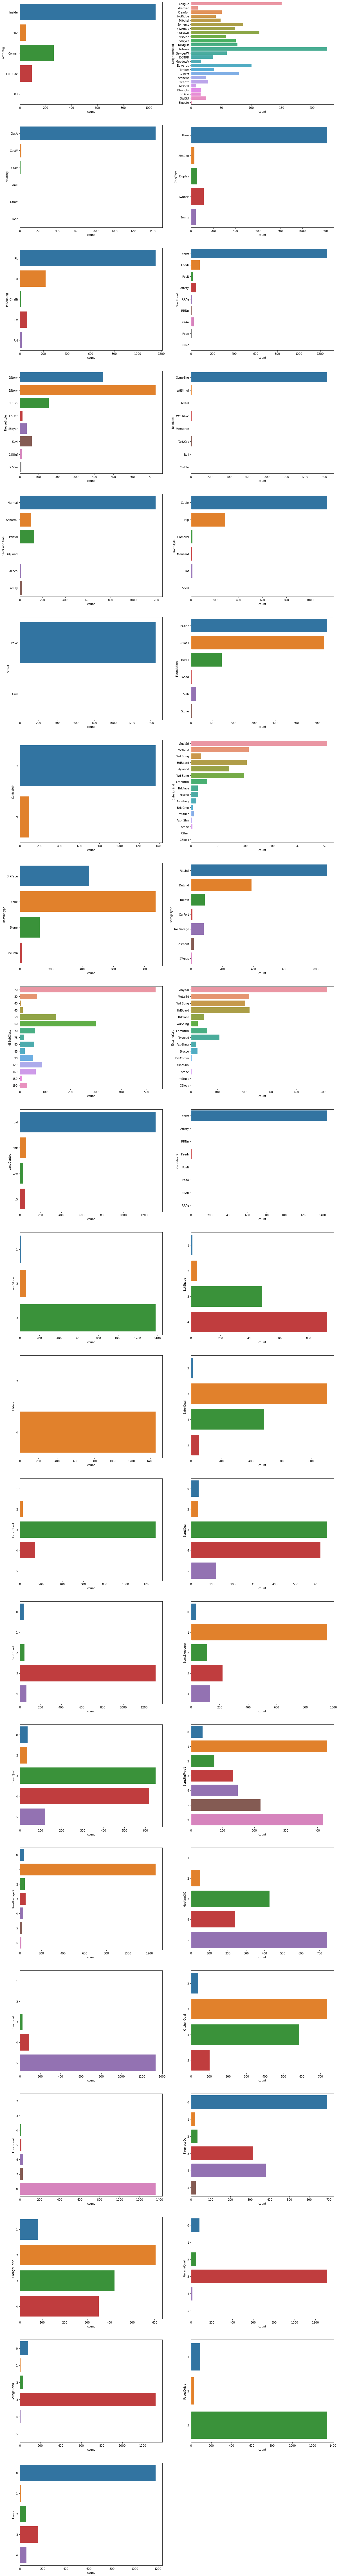

In [29]:
#We will be inspecting all the cateogrical columns now

plt.figure(figsize=(20,8*26))
for i,each in enumerate(cat_vars):
    plt.subplot(26,2,i+1)
    sns.countplot(y=df[each])

In [30]:
#from the above plots, we can spot some features with a consider amount of skewing in the data.
#We will analyze how much skewed the data exactly is, and then take action based on that.
#As a benchmark, features with more than 90% of data belonging to one category can be set as skewed
#We will find which of our categorical columns can be cateogirzed as skewed
skewed_cols = []
for each in cat_vars:
    if max(df[each].value_counts(normalize=True)*100) > 90:
        print(df[each].value_counts(normalize=True)*100)
        print('\n')
        skewed_cols.append(each)

GasA     97.808219
GasW      1.232877
Grav      0.479452
Wall      0.273973
OthW      0.136986
Floor     0.068493
Name: Heating, dtype: float64


CompShg    98.219178
Tar&Grv     0.753425
WdShngl     0.410959
WdShake     0.342466
Membran     0.068493
ClyTile     0.068493
Roll        0.068493
Metal       0.068493
Name: RoofMatl, dtype: float64


Pave    99.589041
Grvl     0.410959
Name: Street, dtype: float64


Y    93.493151
N     6.506849
Name: CentralAir, dtype: float64


Norm      98.972603
Feedr      0.410959
PosN       0.136986
Artery     0.136986
RRNn       0.136986
RRAn       0.068493
PosA       0.068493
RRAe       0.068493
Name: Condition2, dtype: float64


3    94.657534
2     4.452055
1     0.890411
Name: LandSlope, dtype: float64


4    99.931507
2     0.068493
Name: Utilities, dtype: float64


5    91.438356
4     6.438356
3     1.849315
2     0.205479
1     0.068493
Name: Electrical, dtype: float64


8    93.150685
6     2.328767
7     2.123288
5     1.027397
4     0.95890

In [31]:
#We now have the following heavily skewed columns where more than 90% of values belong to a single category only
skewed_cols

['Heating',
 'RoofMatl',
 'Street',
 'CentralAir',
 'Condition2',
 'LandSlope',
 'Utilities',
 'Electrical',
 'Functional',
 'GarageCond',
 'PavedDrive']

In [32]:
#Dropping heavily skewed columns for a cleaner dataset
df.drop(skewed_cols, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 62 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   LotShape       1460 non-null   int64  
 6   LandContour    1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   Condition1     1460 non-null   object 
 10  BldgType       1460 non-null   object 
 11  HouseStyle     1460 non-null   object 
 12  OverallQual    1460 non-null   int64  
 13  OverallCond    1460 non-null   int64  
 14  RoofStyle      1460 non-null   object 
 15  Exterior1st    1460 non-null   object 
 16  Exterior2nd    1460 non-null   object 
 17  MasVnrType     1460 non-null   object 
 18  MasVnrAr

In [33]:
#We now look at how the numerical variables are spread
num_vars = list(df.drop('Id',axis=1)._get_numeric_data().columns)
num_vars

['LotFrontage',
 'LotArea',
 'LotShape',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'Fence',
 'MiscVal',
 'SalePrice',
 'Age']

In [34]:
len(num_vars)

46

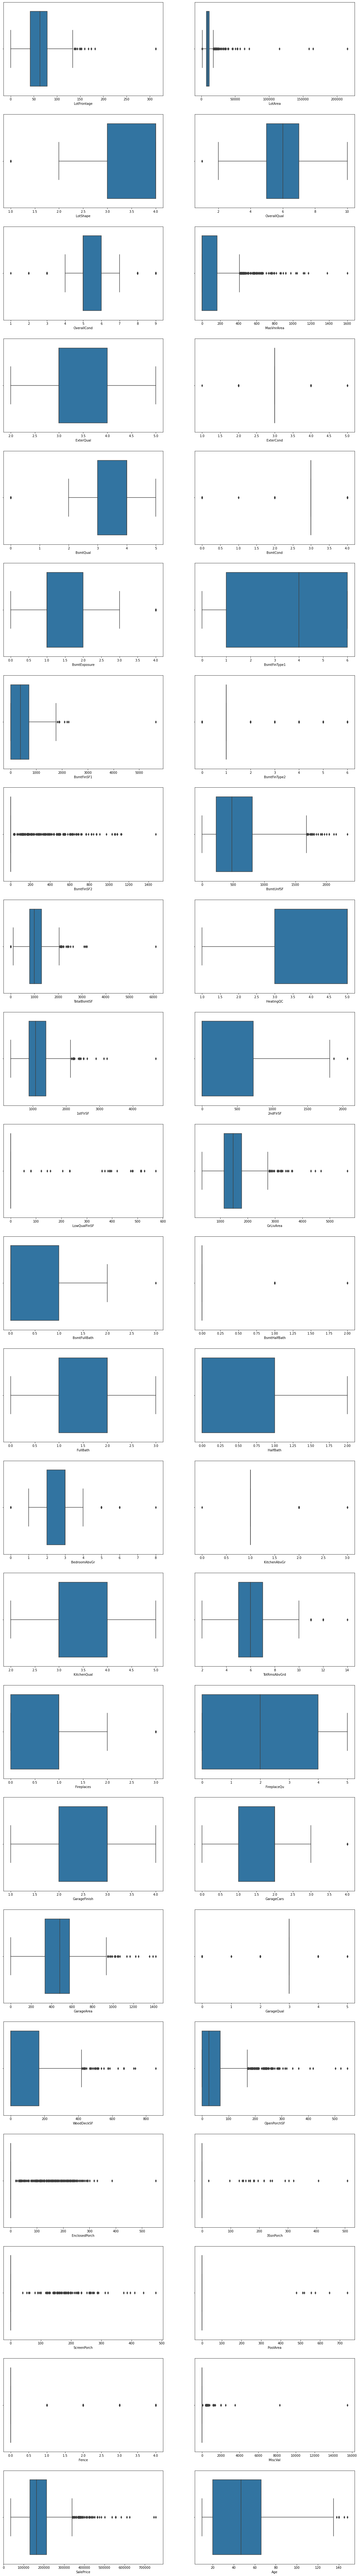

In [35]:
#We will be inspecting all the numerical columns now

plt.figure(figsize=(20,8*22))
for i,each in enumerate(num_vars):
    plt.subplot(27,2,i+1)
    sns.boxplot(x=df[each])

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

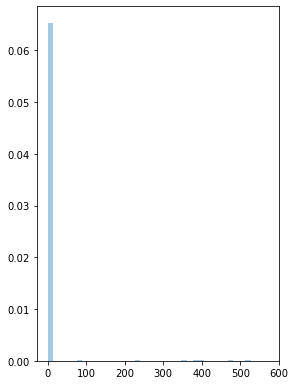

In [36]:
#Certain features are highly skewed here. We can drop them to simplify our model
#before dropping, we look at their actual spread
i=1
plt.figure(figsize=(20,30))
for each in ['LowQualFinSF','ExterCond','BsmtCond','BsmtFinType2','BsmtFinSF2','BsmtHalfBath','KitchenAbvGr','GarageQual','PoolArea','Fence','EnclosedPorch','ScreenPorch','MiscVal','3SsnPorch']:
    plt.subplot(4,4,i)
    sns.distplot(df[each])
    i+=1

In [37]:
#Dropping more skewed features
df.drop(['LowQualFinSF','ExterCond','BsmtCond','BsmtFinType2','BsmtFinSF2','BsmtHalfBath','KitchenAbvGr','GarageQual','PoolArea','Fence','EnclosedPorch','ScreenPorch','MiscVal','3SsnPorch'],axis=1,inplace=True)

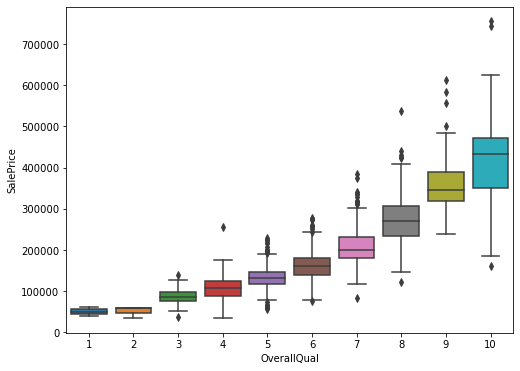

In [38]:
#let's see how sale price is varying across overall quality rating of the house
data = pd.concat([df['SalePrice'], df['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
# fig.axis(ymin=0, ymax=800000);

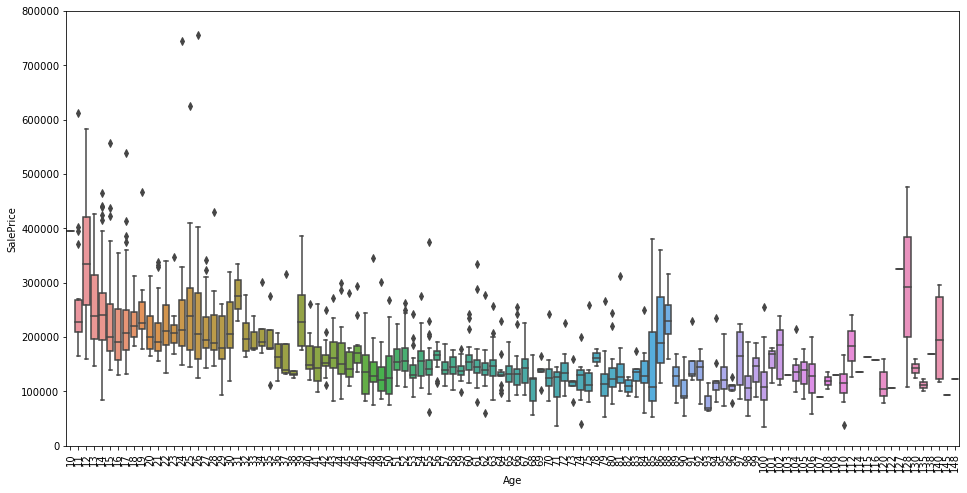

In [39]:
#Sale price also is related to age of house
#high age does not necessarily mean that the price would be low, but a general slightly downward trend is seen
data = pd.concat([df['SalePrice'], df['Age']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='Age', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

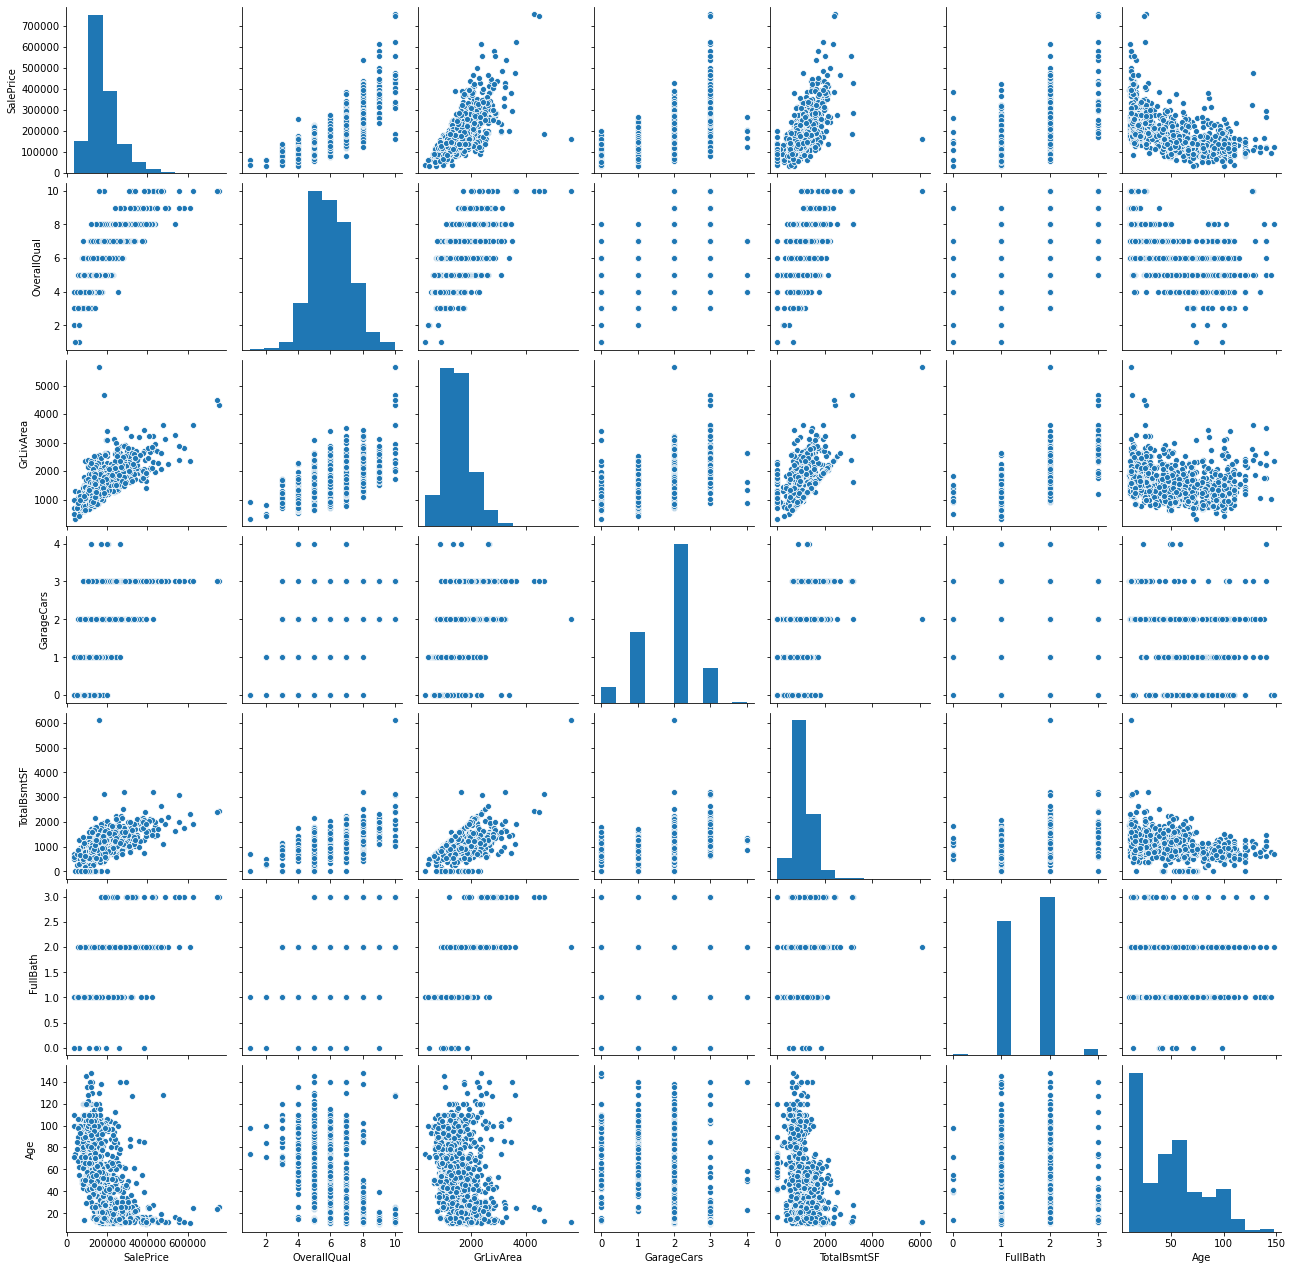

In [40]:
#We can see how some of the important looking features have an impact on each other
sns.pairplot(df[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'Age']], size = 2.5)
plt.show()

* We find there is a considerable amount of variance in the data
* We choose not to perform outlier value treatment, since these features are what might be impacting prices of the house

## Transforming the dependent variable to a normal distribution

To satisfy the assumptions of linear regression, the target variable (dependent variable) must be normally distributed. We can see in the distplot below that ours is highly skewed towards the right. We will now deal with this problem to get better performance

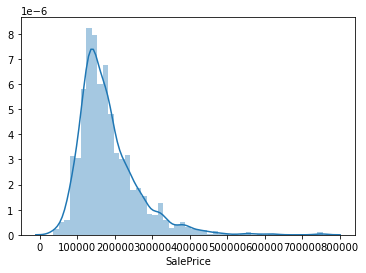

In [41]:
#target variable
sns.distplot(df['SalePrice'])

In [42]:
#We note that the target (dependent) variable does not have a purely normal distribution and there some skewness.

In [43]:
#The variable is quite skewed, and all the values are positive (boxcox can be used here)
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [44]:
#There is a high degree of skew in this column
df.SalePrice.skew()

1.8828757597682129

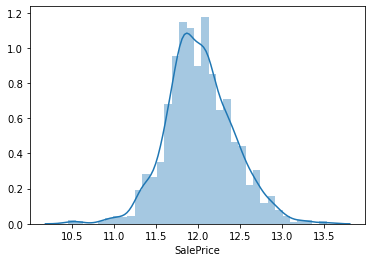

In [45]:
#We try log transformation
from math import log
sns.distplot(df.SalePrice.apply(lambda x: log(x)))

In [46]:
#We are able to get the skew down to a great extent by using log transform
df.SalePrice.apply(lambda x: log(x)).skew()

0.12133506220520406

In [47]:
#We can use Box-Cox Transform to reduce the skew further and make the data resemble a normal distribution
from scipy import stats as ss
df['SalePrice'] = pd.Series(ss.boxcox(df.SalePrice)[0])
df.SalePrice.skew()

-0.008652893640830005

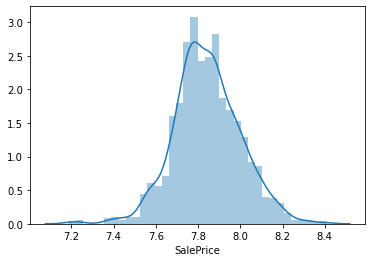

In [48]:
#We can see that the distribution is much closer to normal now, hence we can fit a linear regression model effectively
sns.distplot(df.SalePrice)

## Getting dummy variables for categorical features

In [49]:
#Updating list of categorical variables
cat_vars = list(set(df.drop('Id',axis=1).columns) - set(df._get_numeric_data().columns))
cat_vars

['MSSubClass',
 'Exterior1st',
 'SaleCondition',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'LandContour',
 'RoofStyle',
 'Foundation',
 'MSZoning',
 'HouseStyle',
 'Exterior2nd',
 'MasVnrType',
 'GarageType']

In [50]:
#creating dataframe with dummy variables
dummy = pd.get_dummies(df[cat_vars], drop_first = True)
dummy.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,LandContour_HLS,LandContour_Low,LandContour_Lvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No Garage
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0


In [51]:
#merging dummy variables into original dataframe
df = pd.concat([df,dummy],axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 169 entries, Id to GarageType_No Garage
dtypes: float64(3), int64(30), object(15), uint8(121)
memory usage: 720.1+ KB


In [52]:
#dropping original categorical variables that have been dummified
df.drop(cat_vars,axis=1,inplace=True)
df.shape

(1460, 154)

## Test-Train split

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
x = df.drop(['SalePrice','Id'], axis = 1)
y = df[['SalePrice']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 44)

In [55]:
x_train.shape

(1095, 152)

In [56]:
x_test.shape

(365, 152)

In [57]:
y_train.shape

(1095, 1)

In [58]:
y_test.shape

(365, 1)

## Scaling of numerical features

In [59]:
#To be able to interpret the final model, and for a faster convergence, we will scale our features
#We have chosen MinMax Scaler for the process

In [60]:
from sklearn.preprocessing import MinMaxScaler

In [61]:
scaler = MinMaxScaler() #initializing minmaxscaler
num_vars = list(set(num_vars) - set(['KitchenAbvGr', 'ScreenPorch', 'Fence', 'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'BsmtCond', 'EnclosedPorch', 'LowQualFinSF', 'MiscVal', 'GarageQual', 'BsmtFinSF2', 'BsmtFinType2', 'ExterCond','SalePrice'])) #removing saleprice since it is not in x_train now

In [62]:
#We will be scaling only the orignal continous variables. Dummy variables can be used as-is.
x_train[list(num_vars)].describe()

,LotArea,1stFlrSF,BsmtFinType1,OverallCond,BsmtUnfSF,BsmtQual,GarageFinish,BsmtFinSF1,BedroomAbvGr,OpenPorchSF,2ndFlrSF,Fireplaces,GarageArea,KitchenQual,HalfBath,TotalBsmtSF,MasVnrArea,WoodDeckSF,BsmtFullBath,OverallQual,GrLivArea,FullBath,FireplaceQu,GarageCars,LotShape,HeatingQC,Age,LotFrontage,BsmtExposure,ExterQual,TotRmsAbvGrd
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,10585.533333,1174.587215,3.559817,5.562557,570.246575,3.493151,2.719635,453.461187,2.882192,46.794521,348.622831,0.613699,477.978082,3.511416,0.389041,1069.564384,106.187215,93.802740,0.420091,6.122374,1528.781735,1.562557,1.825571,1.788128,3.576256,4.125114,48.322374,57.211872,1.601826,3.392694,6.564384
std,9165.568230,394.371040,2.094616,1.113103,444.754799,0.880262,0.889163,465.639938,0.832280,66.321283,438.990563,0.643910,213.122278,0.664872,0.506149,447.521273,185.011390,127.759055,0.513758,1.388646,534.224087,0.543757,1.808896,0.741093,0.585772,0.968356,29.859715,36.026179,1.044878,0.577726,1.629036
min,1300.000000,334.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,334.000000,0.000000,0.000000,0.000000,1.000000,1.000000,10.000000,0.000000,0.000000,2.000000,2.000000
25%,7667.500000,888.500000,1.000000,5.000000,224.000000,3.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,337.000000,3.000000,0.000000,804.000000,0.000000,0.000000,0.000000,5.000000,1140.000000,1.000000,0.000000,1.000000,3.000000,3.000000,20.000000,40.000000,1.000000,3.000000,6.000000
50%,9572.000000,1098.000000,4.000000,5.000000,476.000000,4.000000,3.000000,387.000000,3.000000,24.000000,0.000000,1.000000,480.000000,3.000000,0.000000,1004.000000,0.000000,0.000000,0.000000,6.000000,1472.000000,2.000000,2.000000,2.000000,4.000000,4.000000,46.000000,63.000000,1.000000,3.000000,6.000000
75%,11740.500000,1418.000000,6.000000,6.000000,812.500000,4.000000,3.000000,719.500000,3.000000,69.000000,729.500000,1.000000,576.000000,4.000000,1.000000,1303.000000,168.000000,168.000000,1.000000,7.000000,1795.500000,2.000000,4.000000,2.000000,4.000000,5.000000,66.000000,79.000000,2.000000,4.000000,7.000000
max,164660.000000,4692.000000,6.000000,9.000000,2336.000000,5.000000,4.000000,5644.000000,8.000000,547.000000,2065.000000,3.000000,1418.000000,5.000000,2.000000,6110.000000,1600.000000,857.000000,2.000000,10.000000,5642.000000,3.000000,5.000000,4.000000,4.000000,5.000000,140.000000,313.000000,4.000000,5.000000,14.000000


In [63]:
#fitting the scaler on train set and transforming variables
x_train[num_vars] = scaler.fit_transform(x_train[num_vars])
x_train[num_vars].describe()

,LotArea,1stFlrSF,BsmtFinType1,OverallCond,BsmtUnfSF,BsmtQual,GarageFinish,BsmtFinSF1,BedroomAbvGr,OpenPorchSF,2ndFlrSF,Fireplaces,GarageArea,KitchenQual,HalfBath,TotalBsmtSF,MasVnrArea,WoodDeckSF,BsmtFullBath,OverallQual,GrLivArea,FullBath,FireplaceQu,GarageCars,LotShape,HeatingQC,Age,LotFrontage,BsmtExposure,ExterQual,TotRmsAbvGrd
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,0.056841,0.192884,0.593303,0.570320,0.244112,0.698630,0.573212,0.080344,0.360274,0.085548,0.168825,0.204566,0.337079,0.503805,0.194521,0.175051,0.066367,0.109455,0.210046,0.569153,0.225091,0.520852,0.365114,0.447032,0.858752,0.781279,0.294787,0.182786,0.400457,0.464231,0.380365
std,0.056107,0.090494,0.349103,0.139138,0.190392,0.176052,0.296388,0.082502,0.104035,0.121245,0.212586,0.214637,0.150298,0.221624,0.253075,0.073244,0.115632,0.149077,0.256879,0.154294,0.100645,0.181252,0.361779,0.185273,0.195257,0.242089,0.229690,0.115100,0.261219,0.192575,0.135753
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.038978,0.127237,0.166667,0.500000,0.095890,0.600000,0.333333,0.000000,0.250000,0.000000,0.000000,0.000000,0.237659,0.333333,0.000000,0.131588,0.000000,0.000000,0.000000,0.444444,0.151846,0.333333,0.000000,0.250000,0.666667,0.500000,0.076923,0.127796,0.250000,0.333333,0.333333
50%,0.050637,0.175310,0.666667,0.500000,0.203767,0.800000,0.666667,0.068568,0.375000,0.043876,0.000000,0.333333,0.338505,0.333333,0.000000,0.164321,0.000000,0.000000,0.000000,0.555556,0.214393,0.666667,0.400000,0.500000,1.000000,0.750000,0.276923,0.201278,0.250000,0.333333,0.333333
75%,0.063911,0.248738,1.000000,0.625000,0.347817,0.800000,0.666667,0.127481,0.375000,0.126143,0.353269,0.333333,0.406206,0.666667,0.500000,0.213257,0.105000,0.196033,0.500000,0.666667,0.275339,0.666667,0.800000,0.500000,1.000000,1.000000,0.430769,0.252396,0.500000,0.666667,0.416667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
#Scaling features in test set using the scaler fitted on train set
x_test[num_vars] = scaler.transform(x_test[num_vars])

We will first begin by running Recursive Feature Elimination to determine the top 30 most important features by fitting a linear regression model on the data.

## Building the Model

## RFE

In [65]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
from sklearn.feature_selection import RFE
rfe = RFE(linreg, 30)             # running RFE with 30 variables as output
rfe = rfe.fit(x_train, y_train)
print(rfe.support_)

[ True  True False  True  True False False  True False False False False
 False  True False False  True  True False False False False  True  True
 False False  True False False False  True False False False False False
 False False False False False False  True  True False False False  True
 False False False False False False False False False False False  True
 False False False False False False False False False False False  True
 False  True  True False False False False False False False  True  True
 False False False False  True  True False False False False False False
  True False False False False False False False False False False False
 False False  True False False False False False False  True  True  True
  True False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False]


In [66]:
#columns chosen by running RFE
cols=x_train.columns[rfe.support_]
cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'BsmtQual',
       'HeatingQC', 'GrLivArea', 'BsmtFullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'Age', 'MSSubClass_160', 'MSSubClass_180',
       'Exterior1st_BrkFace', 'SaleCondition_AdjLand', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Condition1_RRAe', 'RoofStyle_Mansard', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'Exterior2nd_Brk Cmn'],
      dtype='object')

In [67]:
import statsmodels.api as sm
x_train_rfe = sm.add_constant(x_train[list(cols)])

In [68]:
#Building a basic model with the selected features to gauge performance

lm = sm.OLS(y_train, x_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     291.1
Date:                Mon, 30 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:11:27   Log-Likelihood:                 1687.1
No. Observations:                1095   AIC:                            -3312.
Df Residuals:                    1064   BIC:                            -3157.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.13

Now we can choose to proceed with the set of features identified by RFE, but we can also take the route of directly going to ridge and lasso techniques. We can let the lasso model take care of feature selection as well. 

## Ridge Regression

In [69]:
#List of parameters (alpha values) to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()
%time
# cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 1)
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    3.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [70]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.012023,0.004928,0.006108,0.000569,0.0001,{'alpha': 0.0001},0.823831,0.879795,0.834613,0.845782,0.872595,0.851323,0.021582,24,0.922523,0.915727,0.924678,0.919550,0.916033,0.919702,0.003522
1,0.009515,0.000823,0.006642,0.001511,0.001,{'alpha': 0.001},0.823817,0.879748,0.834745,0.845917,0.872695,0.851384,0.021565,23,0.922522,0.915726,0.924677,0.919550,0.916031,0.919701,0.003521
2,0.009355,0.000362,0.005821,0.000038,0.01,{'alpha': 0.01},0.823855,0.879383,0.835664,0.847219,0.873241,0.851872,0.021367,22,0.922485,0.915704,0.924609,0.919542,0.915974,0.919663,0.003514
3,0.009520,0.000281,0.005951,0.000309,0.05,{'alpha': 0.05},0.825010,0.878445,0.837357,0.851620,0.874243,0.853335,0.020631,20,0.922306,0.915587,0.924319,0.919425,0.915776,0.919483,0.003472
4,0.009417,0.000164,0.005795,0.000049,0.1,{'alpha': 0.1},0.826595,0.877602,0.838472,0.855150,0.875156,0.854595,0.019982,19,0.922096,0.915432,0.924085,0.919193,0.915593,0.919280,0.003448


In [71]:
#this is the best value of alpha identified by grid search cv
model_cv.best_params_

{'alpha': 4.0}

In [72]:
#this is the best score obtained by grid search on the validation set
model_cv.best_score_

0.8663809457586472

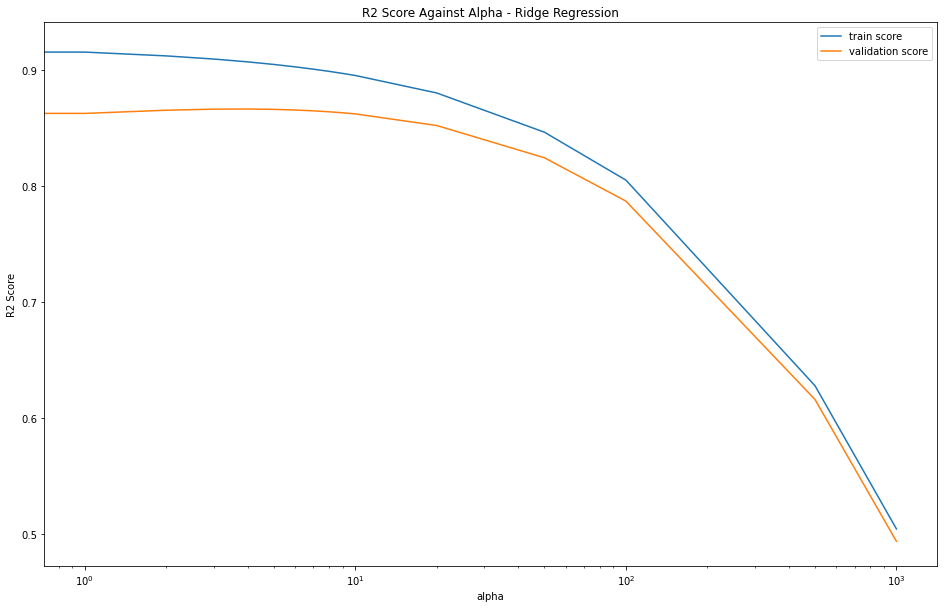

In [73]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')
plt.figure(figsize=(16,10))

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score Against Alpha - Ridge Regression")
plt.legend(['train score', 'validation score'], loc='upper right')
plt.xscale('log')
plt.show()

In [74]:
#Selecting the optimum value of alpha as 4.0
ridge = Ridge(alpha = 4.0)
ridge.fit(x_train, y_train)
#predict
y_train_pred = ridge.predict(x_train)
y_test_pred = ridge.predict(x_test)
#Checking r2 score on train
print('r2 score for Train set')
print(metrics.r2_score(y_true = y_train, y_pred = y_train_pred))
print('r2 score for Test set')
print(metrics.r2_score(y_true = y_test, y_pred = y_test_pred))


r2 score for Train set
0.9045280752215419
r2 score for Test set
0.8932097820119711


In [75]:
# ridge model parameters
model_parameters = list(ridge.coef_)
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters[1]]
cols = x_train.columns
cols = cols.insert(0, "constant")
ridge_f = list(zip(cols, model_parameters))
ridge_f

[('constant', -0.017),
 ('LotFrontage', 0.029),
 ('LotArea', -0.003),
 ('LotShape', 0.154),
 ('OverallQual', 0.108),
 ('OverallCond', 0.02),
 ('MasVnrArea', 0.016),
 ('ExterQual', 0.052),
 ('BsmtQual', 0.032),
 ('BsmtExposure', 0.023),
 ('BsmtFinType1', 0.005),
 ('BsmtFinSF1', 0.011),
 ('BsmtUnfSF', 0.023),
 ('TotalBsmtSF', 0.034),
 ('HeatingQC', 0.082),
 ('1stFlrSF', 0.073),
 ('2ndFlrSF', 0.1),
 ('GrLivArea', 0.036),
 ('BsmtFullBath', 0.063),
 ('FullBath', 0.042),
 ('HalfBath', 0.038),
 ('BedroomAbvGr', 0.044),
 ('KitchenQual', 0.067),
 ('TotRmsAbvGrd', 0.029),
 ('Fireplaces', 0.025),
 ('FireplaceQu', 0.007),
 ('GarageFinish', 0.073),
 ('GarageCars', 0.037),
 ('GarageArea', 0.023),
 ('WoodDeckSF', 0.002),
 ('OpenPorchSF', -0.04),
 ('Age', -0.037),
 ('MSSubClass_30', -0.004),
 ('MSSubClass_40', -0.013),
 ('MSSubClass_45', 0.001),
 ('MSSubClass_50', -0.008),
 ('MSSubClass_60', 0.02),
 ('MSSubClass_70', 0.01),
 ('MSSubClass_75', 0.0),
 ('MSSubClass_80', 0.001),
 ('MSSubClass_85', -0.003)

In [76]:
d = {'Feature':list(list(zip(*ridge_f))[0]),'Coeff':list(list(zip(*ridge_f))[1])}
ridge_params = pd.DataFrame(data = d)

In [77]:
#Let's see what is the importance given to each feature by our model
ridge_params.reindex(ridge_params.Coeff.abs().sort_values(ascending = False).index)

,Feature,Coeff
3,LotShape,0.154
4,OverallQual,0.108
16,2ndFlrSF,0.100
14,HeatingQC,0.082
15,1stFlrSF,0.073
26,GarageFinish,0.073
22,KitchenQual,0.067
18,BsmtFullBath,0.063
119,MSZoning_RH,0.054
7,ExterQual,0.052


#### Ridge Model Explained
* Using ridge regression to regularize our parameters, we were able to determine the value of alpha (hyperparameter) to be optimal at 4.0
* Upon choosing this value, our model performs at a train set best r-squared of 0.87 during 5-fold cross validation. 
* We obtained a test data r2 value of 0.89 on fitting the model on training data (which gave train data r-squared of 0.90, indicating a good stable model)
* The important features can be observed in the sorted dataframe in the above cell.
    * OverallQual - High rating for the overall quality tends to bump the price up
    * LotShape - Regularly shaped lots would fetch a higher price for the house
    * 2nd/1st Floor Area - The area of both floors contribute to the price of the house.
    * HeatingQC - Houses equipped with better heating fetch better prices
    * GarageFinish - Better finish in the garage causes bump in price. 
    * KitchenQual - A hgher quality kitchen adds to the price
    * Basements that contain a full bath add value a lot.
    * High density residental zones are a major selling point
    * The quality of material used on the exterior is also being observed to impact the cost considerably.
    * There are certain neighborhood which are more preferred as well: 
        * Somerset
        * College Creek
        * North Ridge

## Lasso Regression

In [78]:
#List of parameters (alpha values) to tune
params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


lasso = Lasso()
%time
# cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train, y_train) 

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    4.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.01,
                                   0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,
                                   9.0, ...]},
             return_train_score=True, scoring='r2', verbose=1)

In [79]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head(50)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.029589,0.005478,0.007548,0.001105,0.0001,{'alpha': 0.0001},0.807522,0.864935,0.889760,0.866908,0.912612,0.868348,0.035018,4,0.922051,0.914238,0.911050,0.910245,0.905110,0.912539,0.005586
1,0.016113,0.002184,0.006174,0.000087,0.0002,{'alpha': 0.0002},0.819713,0.863376,0.893024,0.867304,0.910935,0.870871,0.030925,2,0.913851,0.908075,0.902252,0.905902,0.895531,0.905122,0.006095
2,0.013323,0.000946,0.006612,0.001292,0.0003,{'alpha': 0.0003},0.824892,0.863273,0.893320,0.866670,0.909109,0.871453,0.028823,1,0.908728,0.903611,0.896098,0.901883,0.891468,0.900358,0.006002
3,0.011976,0.000275,0.005810,0.000096,0.0004,{'alpha': 0.0004},0.825074,0.861364,0.891167,0.864299,0.906451,0.869671,0.027934,3,0.905988,0.899512,0.892564,0.897952,0.887692,0.896742,0.006229
4,0.011572,0.000231,0.005778,0.000069,0.0005,{'alpha': 0.0005},0.825249,0.859240,0.888846,0.861238,0.903208,0.867556,0.026919,5,0.902878,0.895904,0.889299,0.894254,0.884035,0.893274,0.006345
5,0.011441,0.000366,0.005715,0.000077,0.0006,{'alpha': 0.0006},0.825754,0.856450,0.885636,0.858621,0.899296,0.865151,0.025519,6,0.899693,0.892036,0.885512,0.891070,0.879868,0.889636,0.006654
6,0.011275,0.000248,0.005820,0.000117,0.0007,{'alpha': 0.0007},0.825605,0.853579,0.882205,0.856299,0.894736,0.862485,0.024111,7,0.896163,0.888282,0.881578,0.888087,0.875553,0.885932,0.006950
7,0.010689,0.000464,0.005713,0.000044,0.0008,{'alpha': 0.0008},0.825792,0.849998,0.878838,0.853705,0.889647,0.859596,0.022551,8,0.892586,0.884517,0.877691,0.884848,0.871536,0.882236,0.007131
8,0.011169,0.000184,0.005862,0.000103,0.0009,{'alpha': 0.0009},0.826006,0.845752,0.874812,0.851418,0.884832,0.856564,0.021020,9,0.888916,0.880607,0.873745,0.881568,0.867609,0.878489,0.007260
9,0.011170,0.000607,0.005760,0.000074,0.001,{'alpha': 0.001},0.825941,0.841545,0.871008,0.848858,0.880764,0.853623,0.019868,10,0.885288,0.876663,0.869344,0.878043,0.863783,0.874624,0.007416


In [80]:
model_cv.best_params_

{'alpha': 0.0003}

In [81]:
model_cv.best_score_

0.8714526561393161

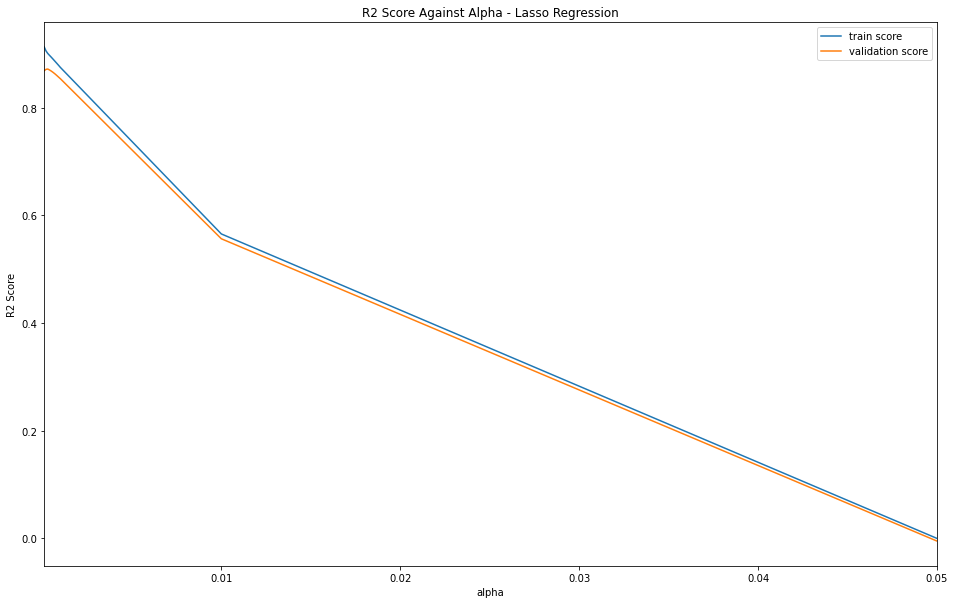

In [82]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float64')
plt.figure(figsize=(16,10))

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score Against Alpha - Lasso Regression")
plt.legend(['train score', 'validation score'], loc='upper right')
# plt.xscale('log')
plt.xlim(0.0001,0.05)
plt.show()


In [83]:
#Selecting the optimum value of alpha as 0.0003
lasso = Lasso(alpha = 0.0003)
lasso.fit(x_train, y_train)
#predict
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)
#Checking r2 score on train
print('r2 score for Train set')
print(metrics.r2_score(y_true = y_train, y_pred = y_train_pred))
print('r2 score for Test set')
print(metrics.r2_score(y_true = y_test, y_pred = y_test_pred))


r2 score for Train set
0.8972835288126162
r2 score for Test set
0.8900244028781547


In [84]:
# lasso model parameters
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters[1:]]
cols = x_train.columns
cols = cols.insert(0, "constant")
lasso_f = list(zip(cols, model_parameters))
lasso_f

[('constant', -0.0),
 ('LotFrontage', 0.0),
 ('LotArea', -0.0),
 ('LotShape', 0.233),
 ('OverallQual', 0.126),
 ('OverallCond', 0.0),
 ('MasVnrArea', 0.0),
 ('ExterQual', 0.06),
 ('BsmtQual', 0.028),
 ('BsmtExposure', 0.019),
 ('BsmtFinType1', 0.0),
 ('BsmtFinSF1', 0.0),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', 0.031),
 ('HeatingQC', 0.0),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.344),
 ('GrLivArea', 0.034),
 ('BsmtFullBath', 0.044),
 ('FullBath', 0.027),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', 0.035),
 ('KitchenQual', 0.051),
 ('TotRmsAbvGrd', 0.017),
 ('Fireplaces', 0.025),
 ('FireplaceQu', 0.004),
 ('GarageFinish', 0.106),
 ('GarageCars', 0.0),
 ('GarageArea', 0.016),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', -0.032),
 ('Age', -0.035),
 ('MSSubClass_30', -0.0),
 ('MSSubClass_40', -0.0),
 ('MSSubClass_45', 0.002),
 ('MSSubClass_50', -0.0),
 ('MSSubClass_60', 0.0),
 ('MSSubClass_70', -0.0),
 ('MSSubClass_75', -0.0),
 ('MSSubClass_80', 0.0),
 ('MSSubClass_85', -0.0),
 ('MSSubClass_90', -0.0),
 ('MS

In [85]:
d = {'Feature':list(list(zip(*lasso_f))[0]),'Coeff':list(list(zip(*lasso_f))[1])}
lasso_params = pd.DataFrame(data = d)

In [86]:
#Let's see what is the importance given to each feature by our model
lasso_params.reindex(lasso_params.Coeff.abs().sort_values(ascending = False).index)

,Feature,Coeff
16,2ndFlrSF,0.344
3,LotShape,0.233
4,OverallQual,0.126
26,GarageFinish,0.106
7,ExterQual,0.060
22,KitchenQual,0.051
73,Neighborhood_CollgCr,0.046
18,BsmtFullBath,0.044
88,Neighborhood_SawyerW,0.040
83,Neighborhood_NoRidge,0.040


#### Lasso model explained
* Using Lasso regression to regularize our parameters, we were able to determine the value of alpha (hyperparameter) to be optimal at 0.0003
* Lasso has an added benefit of performing feature selection. 
* Upon choosing this value, our model performs at a validation set r-squared of 0.87 during 5-fold cross validation. 
* We obtained a test data r2 value of 0.89 on fitting the model on training data (which gave train data r-squared of 0.90, indicating a good stable model)
* The most important features can be observed in the sorted dataframe in the above cell.
    * 2ndFloorSF - The are of the second floor
    * Lot Shape - The shape of the lot regular/irregular etc. The more it is towards regular, higher is the price
    * OverallQual - High rating (9/10) for the overall quality tends to bump the price up. 
    * ExterQual - The quality of material with which the exterior of house is buuilt
    * GarageFinish - Interiror finish of the garage
    * Some neighborhoods fetch better prices for the house
        * North Ridge
        * College Creek
        * Wayer West
    * Sales which are made as 'partial' will bring the price down considerably. 
    

These models can be further tuned using feature selection techniques like Forward, Backward and Stepwise. 

## Understanding Alpha

### Doubling the values of Alpha

In [87]:
#Doubling the alpha for ridge to 8.0
ridge = Ridge(alpha = 8.0)
ridge.fit(x_train, y_train)
#predict
y_train_pred = ridge.predict(x_train)
y_test_pred = ridge.predict(x_test)
#Checking r2 score on train
print('r2 score for Train set')
print(metrics.r2_score(y_true = y_train, y_pred = y_train_pred))
print('r2 score for Test set')
print(metrics.r2_score(y_true = y_test, y_pred = y_test_pred))

r2 score for Train set
0.8979450717033688
r2 score for Test set
0.8887830506571054


In [88]:
#Ridge Model Parameters
model_parameters = list(ridge.coef_)
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters[1]]
cols = x_train.columns
cols = cols.insert(0, "constant")
ridge_f = list(zip(cols, model_parameters))
#Let's see what is the importance given to each feature by our model
pd.DataFrame(data = {'Feature':list(list(zip(*ridge_f))[0]),'Coeff':list(list(zip(*ridge_f))[1])}).reindex(ridge_params.Coeff.abs().sort_values(ascending = False).index)

,Feature,Coeff
3,LotShape,0.127
4,OverallQual,0.092
16,2ndFlrSF,0.080
14,HeatingQC,0.065
15,1stFlrSF,0.062
26,GarageFinish,0.066
22,KitchenQual,0.065
18,BsmtFullBath,0.062
119,MSZoning_RH,0.037
7,ExterQual,0.049


In [89]:
#Doubling the alpha for lasso to 0.0006
lasso = Lasso(alpha = 0.0006)
lasso.fit(x_train, y_train)
#predict
y_train_pred = lasso.predict(x_train)
y_test_pred = lasso.predict(x_test)
#Checking r2 score on train
print('r2 score for Train set')
print(metrics.r2_score(y_true = y_train, y_pred = y_train_pred))
print('r2 score for Test set')
print(metrics.r2_score(y_true = y_test, y_pred = y_test_pred))


r2 score for Train set
0.8872697375198548
r2 score for Test set
0.8783392436265254


In [90]:
#Lasso Model Parameters
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters[1:]]
cols = x_train.columns
cols = cols.insert(0, "constant")
lasso_f = list(zip(cols, model_parameters))
#Let's see what is the importance given to each feature by our model
d = {'Feature':list(list(zip(*lasso_f))[0]),'Coeff':list(list(zip(*lasso_f))[1])}
lasso_params = pd.DataFrame(data = d)
lasso_params.reindex(lasso_params.Coeff.abs().sort_values(ascending = False).index)

,Feature,Coeff
16,2ndFlrSF,0.300
3,LotShape,0.243
26,GarageFinish,0.113
4,OverallQual,0.103
7,ExterQual,0.059
22,KitchenQual,0.046
21,BedroomAbvGr,0.041
18,BsmtFullBath,0.039
73,Neighborhood_CollgCr,0.037
88,Neighborhood_SawyerW,0.036


We see a dip in the train r-squared for both the models, for both train set and test set. This is to be expected since the model is now more regularized and the fit is less tighter than it was before.

## Re-Run Lasso with Reduced set of input variables

* The top 5 features from the orignal Lasso model were ['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'].
* These will be removed from the training (and test) set, and the model will be re-tuned and re-evaluated.

In [91]:
#List of parameters (alpha values) to tune
params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


lasso = Lasso()
%time
# cross validation
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(x_train.drop(['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'],axis=1), y_train) #top features removed

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    4.0s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.01,
                                   0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,
                                   9.0, ...]},
             return_train_score=True, scoring='r2', verbose=1)

In [92]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.027396,0.002784,0.006632,0.000749,0.0001,{'alpha': 0.0001},0.784184,0.860424,0.884815,0.856704,0.897529,0.856731,0.039319,4,0.916525,0.905889,0.902618,0.902910,0.898280,0.905245,0.006140
1,0.016341,0.005349,0.005856,0.000171,0.0002,{'alpha': 0.0002},0.797065,0.858835,0.890493,0.855123,0.893279,0.858959,0.034692,2,0.908092,0.899101,0.894181,0.897059,0.887925,0.897272,0.006594
2,0.012027,0.000313,0.006013,0.000113,0.0003,{'alpha': 0.0003},0.802064,0.859981,0.891399,0.856092,0.890404,0.859988,0.032503,1,0.901788,0.894248,0.886040,0.892377,0.883475,0.891586,0.006455
3,0.011844,0.000686,0.006129,0.000367,0.0004,{'alpha': 0.0004},0.803368,0.858314,0.889875,0.853102,0.886212,0.858174,0.031050,3,0.898014,0.888849,0.881248,0.888481,0.879356,0.887189,0.006607
4,0.010894,0.000696,0.005857,0.000233,0.0005,{'alpha': 0.0005},0.803457,0.854917,0.887058,0.848968,0.882431,0.855366,0.029909,5,0.894193,0.884790,0.876965,0.884500,0.875331,0.883156,0.006721


In [93]:
model_cv.best_params_

{'alpha': 0.0003}

In [94]:
model_cv.best_score_

0.8599880409071243

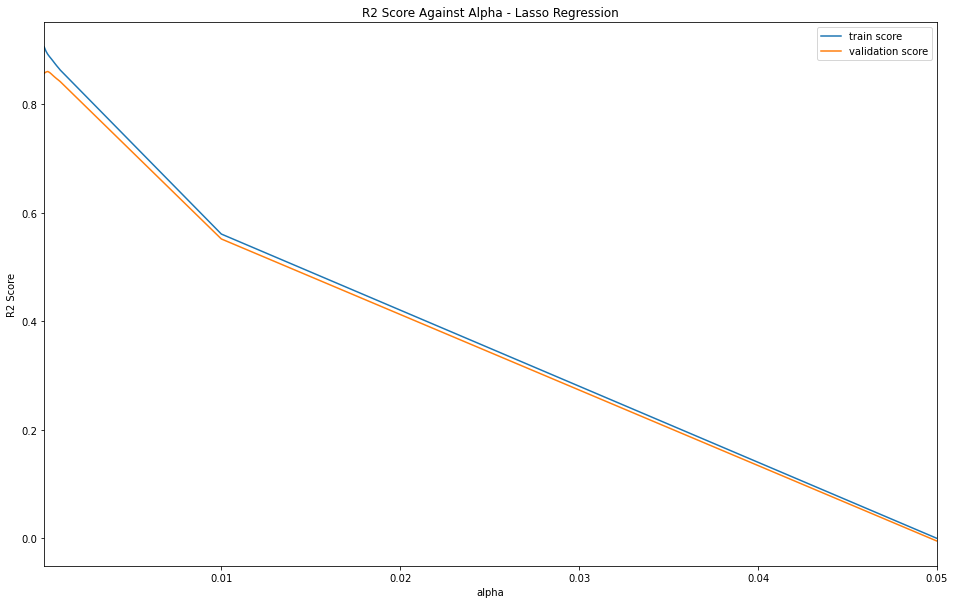

In [95]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float64')
plt.figure(figsize=(16,10))

# plotting
plt.plot(cv_results.loc[cv_results['param_alpha']<=1.0]['param_alpha'], cv_results.loc[cv_results['param_alpha']<=1.0]['mean_train_score'])
plt.plot(cv_results.loc[cv_results['param_alpha']<=1.0]['param_alpha'], cv_results.loc[cv_results['param_alpha']<=1.0]['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2 Score')
plt.title("R2 Score Against Alpha - Lasso Regression")
plt.legend(['train score', 'validation score'], loc='upper right')
plt.xlim(0.0001,0.05)
# plt.xscale('log')
plt.show()

In [96]:
#Selecting the optimum value of alpha as 0.0003
lasso = Lasso(alpha = 0.0003)
lasso.fit(x_train.drop(['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'],axis=1), y_train)
#predict
y_train_pred = lasso.predict(x_train.drop(['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'],axis=1))
y_test_pred = lasso.predict(x_test.drop(['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'],axis=1))
#Checking r2 score on train
print('r2 score for Train set')
print(metrics.r2_score(y_true = y_train, y_pred = y_train_pred))
print('r2 score for Test set')
print(metrics.r2_score(y_true = y_test, y_pred = y_test_pred))


r2 score for Train set
0.8882916933835023
r2 score for Test set
0.8806643355133449


In [97]:
# lasso model parameters
model_parameters = list(lasso.coef_)
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters[1:]]
cols = x_train.drop(['2ndFlrSF','LotShape','OverallQual','ExterQual','GarageFinish'],axis=1).columns
cols = cols.insert(0, "constant")
lasso_f = list(zip(cols, model_parameters))
lasso_f

[('constant', -0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.148),
 ('OverallCond', 0.0),
 ('MasVnrArea', 0.087),
 ('BsmtQual', 0.035),
 ('BsmtExposure', 0.021),
 ('BsmtFinType1', 0.0),
 ('BsmtFinSF1', 0.006),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', 0.034),
 ('HeatingQC', 0.0),
 ('1stFlrSF', 0.448),
 ('GrLivArea', 0.029),
 ('BsmtFullBath', 0.042),
 ('FullBath', 0.026),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', 0.058),
 ('KitchenQual', 0.051),
 ('TotRmsAbvGrd', 0.018),
 ('Fireplaces', 0.036),
 ('FireplaceQu', 0.113),
 ('GarageCars', 0.0),
 ('GarageArea', 0.01),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', -0.075),
 ('Age', -0.036),
 ('MSSubClass_30', -0.0),
 ('MSSubClass_40', -0.0),
 ('MSSubClass_45', 0.0),
 ('MSSubClass_50', -0.0),
 ('MSSubClass_60', 0.014),
 ('MSSubClass_70', 0.0),
 ('MSSubClass_75', -0.0),
 ('MSSubClass_80', -0.0),
 ('MSSubClass_85', -0.002),
 ('MSSubClass_90', -0.0),
 ('MSSubClass_120', -0.014),
 ('MSSubClass_160', -0.0),
 ('MSSubClass_180', -0.0),
 ('MSSubClass_190', 0.0),
 ('Ex

In [98]:
d = {'Feature':list(list(zip(*lasso_f))[0]),'Coeff':list(list(zip(*lasso_f))[1])}
lasso_params = pd.DataFrame(data = d)

In [99]:
#Let's see what is the importance given to each feature by our model
lasso_params.reindex(lasso_params.Coeff.abs().sort_values(ascending = False).index)

,Feature,Coeff
12,1stFlrSF,0.448
2,LotArea,0.148
21,FireplaceQu,0.113
4,MasVnrArea,0.087
25,OpenPorchSF,-0.075
17,BedroomAbvGr,0.058
78,Neighborhood_NoRidge,0.054
18,KitchenQual,0.051
84,Neighborhood_Somerst,0.050
83,Neighborhood_SawyerW,0.046
